In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

from utils import nmf, plot_nmf_components, plot_reconstructed_images

In [2]:
n = 100 # n samples
m = 25 # m features
r = 20

np.random.seed(0)
X = np.abs(np.random.randn(n,m))

# Apply NMF
model = nmf(n_components=r, max_iter=1500, random_state=42, verbose=True)
W = model.fit_transform(X)
H = model.H

# Check reconstruction
X_reconstructed = model.inverse_transform() # W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nFinal reconstruction error: {error:.4f}")

Iteration 500/1500, error: 10.1601
Iteration 1000/1500, error: 10.0173
Iteration 1500/1500, error: 9.9888

Final reconstruction error: 9.9888


# NMS for Facial Feature Extraction

In [3]:
# Load LFW dataset
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = faces.images  # shape (n_samples, height, width)

images_shape = images.shape[1:]
X = faces.data.T  # shape (n_features, n_samples)

print(f"Images shape: (height, width) = {images_shape}")
print(f"Dataset shape: (n,m) = {X.shape}")

Images shape: (height, width) = (50, 37)
Dataset shape: (n,m) = (1850, 1288)


## Training for different ranks

In [6]:
ranks = [5, 10, 20, 30, 40, 50, 75, 100, 150, 200]

os.makedirs("nmf_models", exist_ok=True)

for r in ranks:
    filename = f"nmf_models/nmf_rank_{r}.npz"
    
    if os.path.exists(filename):
        print(f"File for rank {r} already exists. Skipping...")
        continue

    print(f"Training NMF for rank {r}...")
    model = nmf(n_components=r, max_iter=3000, random_state=42)
    W = model.fit_transform(X)
    H = model.H
    error = np.linalg.norm(X - W @ H, 'fro')

    np.savez_compressed(filename, W=W, H=H, error=error)

Training NMF for rank 5...
Training NMF for rank 10...
Training NMF for rank 20...
Training NMF for rank 30...
Training NMF for rank 40...
Training NMF for rank 50...
Training NMF for rank 75...
Training NMF for rank 100...
Training NMF for rank 150...
File for rank 200 already exists. Skipping...


### Reconstruction Error vs. Rank

In [7]:
errors_dic = {}

for r in ranks:
    filename = f"nmf_models/nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        errors_dic[r] = data['error'].item()

ranks = []
errors = []

for r, error in errors_dic.items():
    ranks.append(r)
    errors.append(error)

Elbow at rank: 50


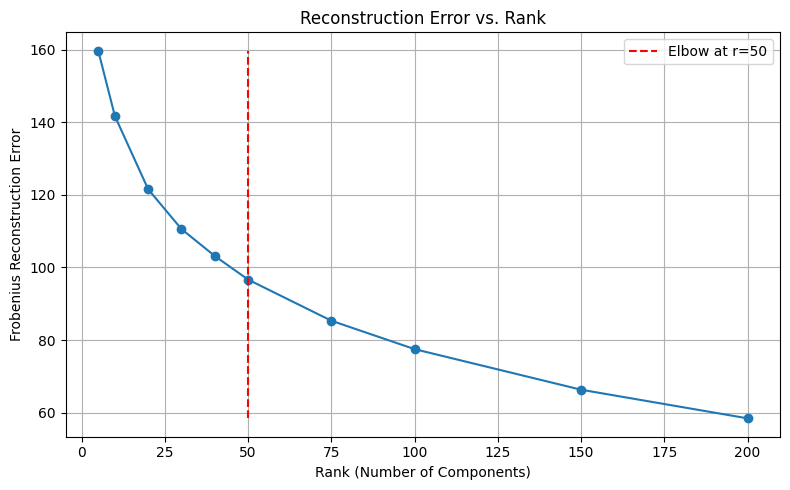

In [8]:
from kneed import KneeLocator

knee = KneeLocator(ranks, errors, curve='convex', direction='decreasing')
print("Elbow at rank:", knee.knee)

# Plot with elbow marked
plt.figure(figsize=(8, 5))
plt.plot(ranks, errors, marker='o')
plt.vlines(knee.knee, min(errors), max(errors), linestyles='dashed', colors='red', label=f"Elbow at r={knee.knee}")
plt.title('Reconstruction Error vs. Rank')
plt.xlabel('Rank (Number of Components)')
plt.ylabel('Frobenius Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Basis components and reconstruction


The reconstruction error for rank 200 is: 58.4350


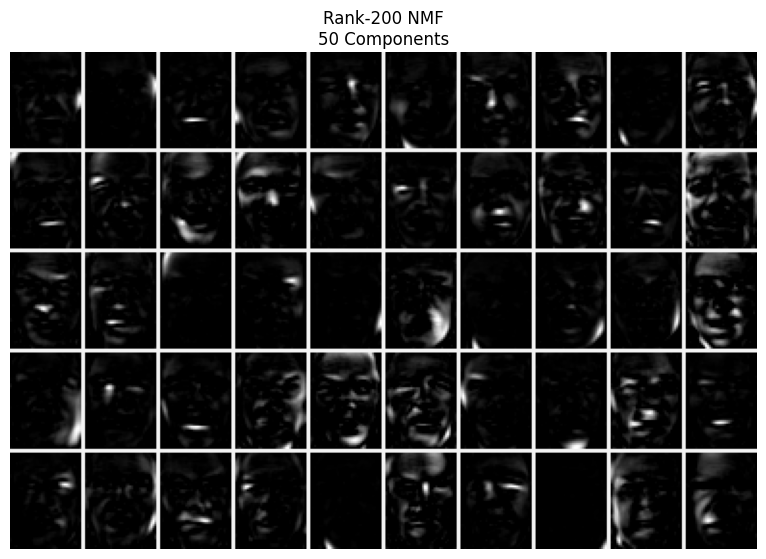

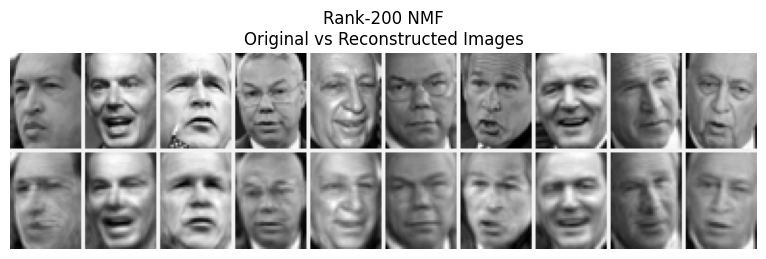

In [9]:
r = 200
data = np.load(f"nmf_models/nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

plot_nmf_components(
    W, image_shape=images_shape, 
    n_components=50, n_cols=10, 
    title=f"Rank-{r} NMF\n50 Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"Rank-{r} NMF\nOriginal vs Reconstructed Images"
)